### Libraries

In [202]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split        
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm


#### Data Preprocessing

In [203]:
desc=''' 
Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)
Speech audio-only files (16bit, 48kHz .wav) from the RAVDESS. Full dataset of speech and song, audio and video (24.8 GB) available from Zenodo. Construction and perceptual validation of the RAVDESS is described in our Open Access paper in PLoS ONE.

Check out our Kaggle Song emotion dataset.

Files

This portion of the RAVDESS contains 1440 files: 60 trials per actor x 24 actors = 1440. The RAVDESS contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech emotions includes calm, happy, sad, angry, fearful, surprise, and disgust expressions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.

File naming convention

Each of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics:

Filename identifiers

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

Vocal channel (01 = speech, 02 = song).

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

Repetition (01 = 1st repetition, 02 = 2nd repetition).

Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename example: 03-01-06-01-02-01-12.wav

Audio-only (03)
Speech (01)
Fearful (06)
Normal intensity (01)
Statement "dogs" (02)
1st Repetition (01)
12th Actor (12)
Female, as the actor ID number is even.


'''
print(desc)

 
Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)
Speech audio-only files (16bit, 48kHz .wav) from the RAVDESS. Full dataset of speech and song, audio and video (24.8 GB) available from Zenodo. Construction and perceptual validation of the RAVDESS is described in our Open Access paper in PLoS ONE.

Check out our Kaggle Song emotion dataset.

Files

This portion of the RAVDESS contains 1440 files: 60 trials per actor x 24 actors = 1440. The RAVDESS contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech emotions includes calm, happy, sad, angry, fearful, surprise, and disgust expressions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.

File naming convention

Each of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers

In [204]:
emotion_dict={
    "01":"neutral",
    "02":"calm",
    "03":"happy",
    "04":"sad",
    "05":"angry",   
    "06":"fearful",
    "07":"disgust",
    "08":"surprised"
}

root_dir = os.path.dirname(os.path.abspath("project.ipynb"))
root_dir = os.path.join(root_dir, "archive")
print("Root directory: ", root_dir)

Root directory:  d:\Deep Learning\speech emotion recognition project\archive


In [205]:
def load_ravdess_dataset(root_dir, emotion_dict):
    data=[]
    labels=[]
    for actor_dir in os.listdir(root_dir):
        actor_path=os.path.join(root_dir,actor_dir)

        if os.path.isdir(actor_path):
            wav_files = [f for f in os.listdir(actor_path) if f.endswith('.wav')]
            for wav_file in wav_files:
                file_path = os.path.join(actor_path, wav_file)
                emotion_label = wav_file.split('-')[2]
                data.append(file_path)
                labels.append(emotion_dict[emotion_label])  
    return data, labels

In [206]:
data_path, emotions_labels= load_ravdess_dataset(root_dir, emotion_dict)
print("Number of samples: ", len(data_path))
for d,(file,label) in enumerate(zip(data_path, emotions_labels)):
    
    print(f"This file {d}: {os.path.basename(file)} has this label :{os.path.basename(label)}")

Number of samples:  1440
This file 0: 03-01-01-01-01-01-01.wav has this label :neutral
This file 1: 03-01-01-01-01-02-01.wav has this label :neutral
This file 2: 03-01-01-01-02-01-01.wav has this label :neutral
This file 3: 03-01-01-01-02-02-01.wav has this label :neutral
This file 4: 03-01-02-01-01-01-01.wav has this label :calm
This file 5: 03-01-02-01-01-02-01.wav has this label :calm
This file 6: 03-01-02-01-02-01-01.wav has this label :calm
This file 7: 03-01-02-01-02-02-01.wav has this label :calm
This file 8: 03-01-02-02-01-01-01.wav has this label :calm
This file 9: 03-01-02-02-01-02-01.wav has this label :calm
This file 10: 03-01-02-02-02-01-01.wav has this label :calm
This file 11: 03-01-02-02-02-02-01.wav has this label :calm
This file 12: 03-01-03-01-01-01-01.wav has this label :happy
This file 13: 03-01-03-01-01-02-01.wav has this label :happy
This file 14: 03-01-03-01-02-01-01.wav has this label :happy
This file 15: 03-01-03-01-02-02-01.wav has this label :happy
This file

### Feature Extraction

In [ ]:
def extract_features(file_path, max_len=173):
    y, sr = librosa.load(file_path, sr=None)
    
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfccs = mfccs.T
    mfccs = (mfccs - np.mean(mfccs)) / np.std(mfccs)

    if mfccs.shape[0] < max_len:
        pad_width = max_len - mfccs.shape[0]
        mfccs = np.pad(mfccs, ((0, pad_width), (0, 0)), mode='constant')
    else:
        mfccs = mfccs[:max_len, :]

    return mfccs


### Dataset

In [287]:
class dataset(Dataset):
    def __init__(self, file_paths, labels):
        self.file_paths = file_paths
        self.labels = labels

    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        feature = extract_features(self.file_paths[idx])
        label = self.labels[idx]    
        return torch.tensor(feature, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [288]:
label_to_idx = {label: idx for idx, label in enumerate(sorted(set(emotions_labels)))}
numeric_labels = [label_to_idx[label] for label in emotions_labels]

In [289]:
train_files, test_files, train_labels, test_labels = train_test_split(data_path, numeric_labels, test_size=0.2,stratify=numeric_labels, random_state=42)
train_dataset = dataset(train_files, train_labels)
test_dataset = dataset(test_files, test_labels)     

train_loader= DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader= DataLoader(test_dataset, batch_size=32, shuffle=False)

for inputs, label in train_loader:
    print("Input shape: ", inputs.shape)
    print("Label shape: ", label.shape)
    break


Input shape:  torch.Size([32, 173, 40])
Label shape:  torch.Size([32])


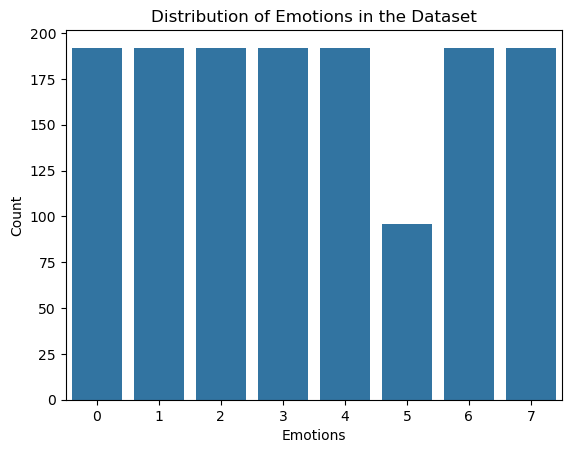

In [290]:
df=pd.DataFrame({'Label':numeric_labels})
sns.countplot(x=df['Label'])
plt.title("Distribution of Emotions in the Dataset")
plt.xlabel("Emotions")
plt.ylabel("Count")
plt.show()

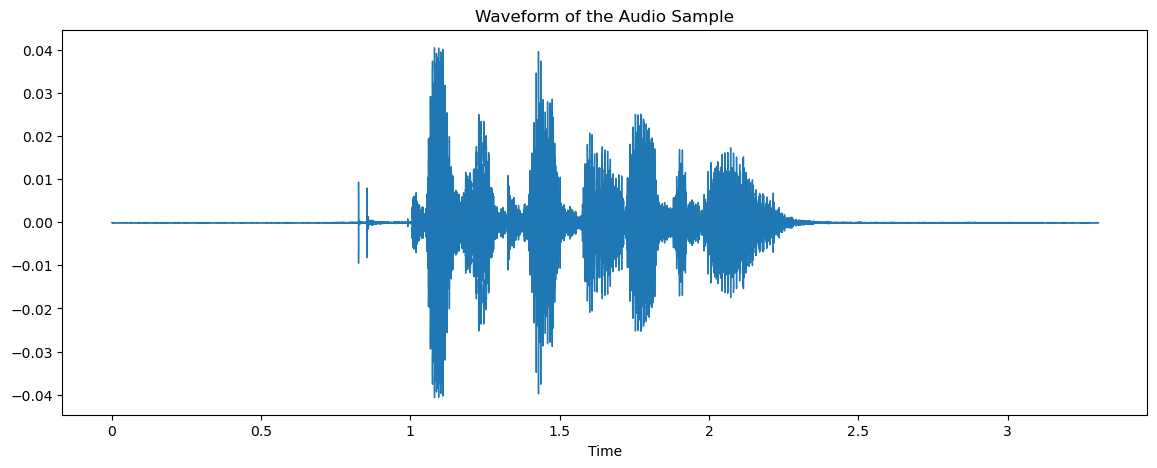

In [291]:
sample=data_path[0]
audio, sr= librosa.load(sample, sr=None)
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio, sr=sr)
plt.title("Waveform of the Audio Sample")   
plt.show()

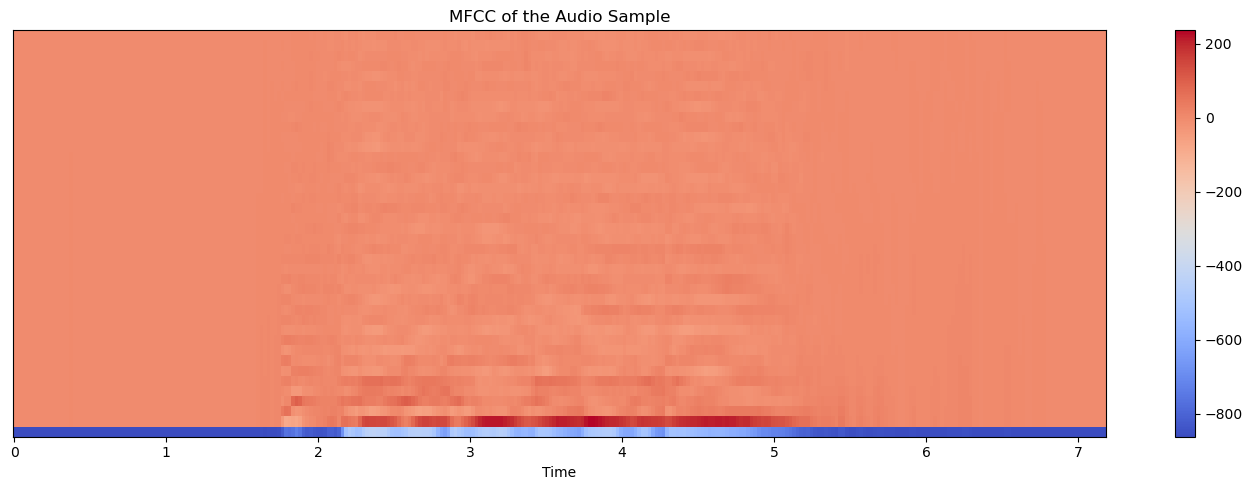

In [292]:
mfcc=librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
plt.figure(figsize=(14, 5))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title("MFCC of the Audio Sample")
plt.tight_layout()
plt.show()

### CNN Model

In [304]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, len=173):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(128*5*21, 256)

        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(256, 8)
        self.dropout = nn.Dropout(0.5)  

          


    def forward(self, x):
        x = x.unsqueeze(1)  
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu4(x)
        
        x = self.fc2(x)
        return x
model = CNN()
print(model)


CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=13440, out_features=256, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=256, out_features=8, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [319]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(numeric_labels),
    y=numeric_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)



### Model Training

In [310]:
num_epochs=10
for epoch in range(num_epochs):
    model.train()
    running_loss=0.0
    correct_preds=0
    total_pred=0

    for inputs, labels in tqdm(train_loader):
        optimizer.zero_grad()
        outputs=model(inputs)
        loss=criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        
        _, predicted=outputs.max(1)
        total_pred+=labels.size(0)
        correct_preds+=(predicted==labels).sum().item()
    epoch_loss=running_loss/len(train_loader)
    epoch_acc=correct_preds/total_pred
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

100%|██████████| 36/36 [00:29<00:00,  1.20it/s]


Epoch [1/10], Loss: 0.3592, Accuracy: 0.87%


100%|██████████| 36/36 [00:38<00:00,  1.06s/it]


Epoch [2/10], Loss: 0.3223, Accuracy: 0.88%


100%|██████████| 36/36 [00:33<00:00,  1.08it/s]


Epoch [3/10], Loss: 0.2169, Accuracy: 0.93%


100%|██████████| 36/36 [00:34<00:00,  1.06it/s]


Epoch [4/10], Loss: 0.2505, Accuracy: 0.92%


100%|██████████| 36/36 [00:32<00:00,  1.09it/s]


Epoch [5/10], Loss: 0.2142, Accuracy: 0.93%


100%|██████████| 36/36 [00:32<00:00,  1.12it/s]


Epoch [6/10], Loss: 0.1598, Accuracy: 0.94%


100%|██████████| 36/36 [00:29<00:00,  1.24it/s]


Epoch [7/10], Loss: 0.1362, Accuracy: 0.95%


100%|██████████| 36/36 [00:33<00:00,  1.08it/s]


Epoch [8/10], Loss: 0.1500, Accuracy: 0.95%


100%|██████████| 36/36 [00:31<00:00,  1.13it/s]


Epoch [9/10], Loss: 0.1439, Accuracy: 0.95%


100%|██████████| 36/36 [00:33<00:00,  1.09it/s]

Epoch [10/10], Loss: 0.1348, Accuracy: 0.96%


In [311]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_loss = test_loss / len(test_loader)
    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

    return accuracy


In [312]:
# Assuming you're done with training
evaluate_model(model, test_loader, criterion, device='cpu') 


Test Loss: 2.2282, Test Accuracy: 50.35%


50.34722222222222

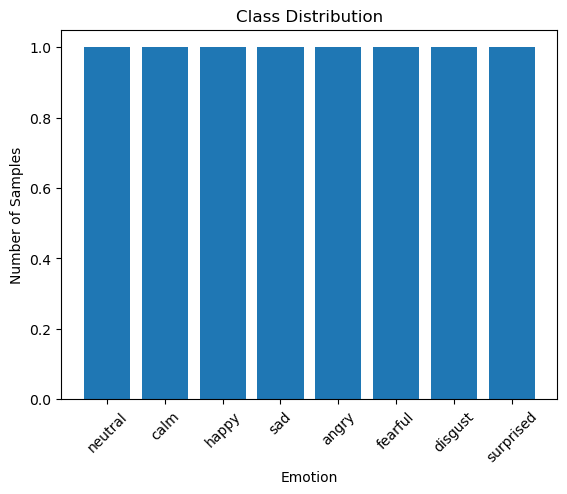

In [313]:
import matplotlib.pyplot as plt

label_names = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
counts = Counter(labels)

plt.bar(counts.keys(), counts.values())
plt.xticks(ticks=range(len(label_names)), labels=label_names, rotation=45)
plt.title("Class Distribution")
plt.xlabel("Emotion")
plt.ylabel("Number of Samples")
plt.show()


In [314]:
all_labels = []
for data, label in train_loader:
    all_labels.extend(label.tolist())

from collections import Counter
print(Counter(all_labels))


Counter({6: 154, 1: 154, 2: 154, 0: 154, 3: 153, 7: 153, 4: 153, 5: 77})


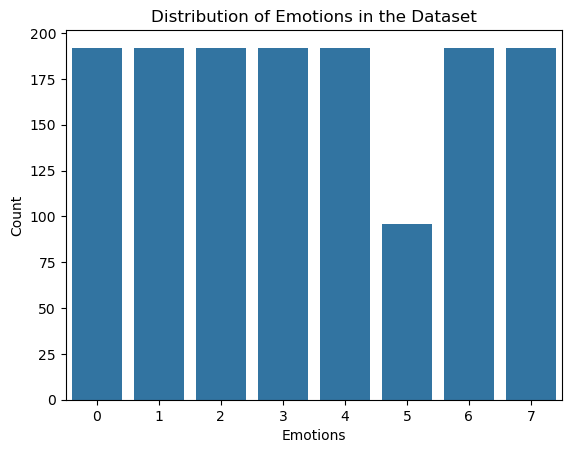

In [317]:
df=pd.DataFrame({'Label':numeric_labels})
sns.countplot(x=df['Label'])
plt.title("Distribution of Emotions in the Dataset")
plt.xlabel("Emotions")
plt.ylabel("Count")
plt.show()

In [320]:
torch.save(model.state_dict(), "cnn_emotion_model.pth")


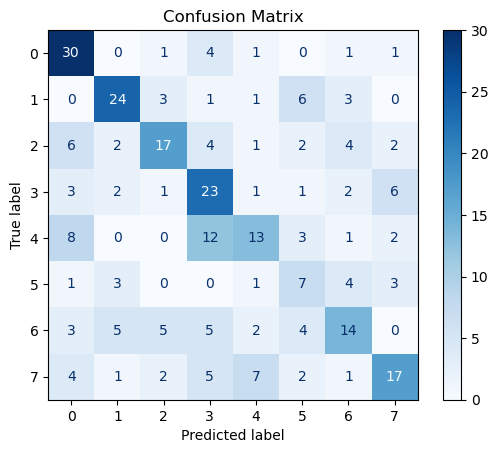

In [324]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        
        true_labels.extend(labels.tolist())
        predicted_labels.extend(preds.tolist())

# Now generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [325]:
from sklearn.metrics import classification_report

print(classification_report(true_labels, predicted_labels, target_names=emotion_names))


              precision    recall  f1-score   support

       angry       0.55      0.79      0.65        38
        calm       0.65      0.63      0.64        38
     disgust       0.59      0.45      0.51        38
     fearful       0.43      0.59      0.49        39
       happy       0.48      0.33      0.39        39
     neutral       0.28      0.37      0.32        19
         sad       0.47      0.37      0.41        38
   surprised       0.55      0.44      0.49        39

    accuracy                           0.50       288
   macro avg       0.50      0.50      0.49       288
weighted avg       0.51      0.50      0.50       288



### Demo

In [329]:
model = CNN()
model.load_state_dict(torch.load("cnn_emotion_model.pth", map_location=torch.device('cpu')))
model.eval()


C:\Users\shahd\AppData\Local\Temp\ipykernel_1736\2540625680.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cnn_emotion_model.pth", map

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=13440, out_features=256, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=256, out_features=8, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
import numpy as np
import librosa

# Dummy emotion names, adjust as per your label mapping
emotion_names = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfcc = mfcc.T  # shape: (time, n_mfcc) → (173, 40)
    mfcc = librosa.util.fix_length(mfcc, size=173, axis=0)  # Ensure 173 frames
    return mfcc

def predict_emotion(file_path, model):
    features = extract_features(file_path)
    features = torch.tensor(features, dtype=torch.float32).unsqueeze(0)  # (1, 173, 40)

    with torch.no_grad():
        outputs = model(features)
        prediction = torch.argmax(outputs, dim=1).item()
    
    return emotion_names[prediction]


In [331]:
demo_file = "testfile.wav"  # Path to your demo file
print("Predicted Emotion:", predict_emotion(demo_file, model))


Predicted Emotion: neutral
